<a href="https://colab.research.google.com/github/kridtapon/HMA-CMF-Alpha/blob/main/HMA_CMF_Alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninst

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Chaikin Money Flow (CMF)
def calculate_cmf(df, period=20):
    mf_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    mf_volume = mf_multiplier * df['Volume']
    df['CMF'] = mf_volume.rolling(window=period).sum() / df['Volume'].rolling(window=period).sum()
    return df['CMF']

# Hull Moving Average (HMA)
def calculate_hma(df, period=20):
    wma_half = df['Close'].rolling(window=period // 2).mean()
    wma_full = df['Close'].rolling(window=period).mean()
    hma = (2 * wma_half - wma_full).rolling(window=int(np.sqrt(period))).mean()
    df['HMA'] = hma
    return df['HMA']

# Define the stock symbol and time period
symbol = 'NVDA'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate CMF and HMA
df['CMF'] = calculate_cmf(df, period=12)
df['HMA'] = calculate_hma(df, period=70)

# Calculate HMA slope
df['HMA_Slope'] = df['HMA'] - df['HMA'].shift(1)

# Define entry and exit signals based on CMF and HMA
df['Entry'] = (
    (df['CMF'] > 0) &  # Bullish CMF
    (df['HMA_Slope'] > 0) &  # HMA sloping upward
    (df['CMF'].shift(1) <= 0)  # Previous CMF was <= 0
)

df['Exit'] = (
    (df['CMF'] < 0) &  # Bearish CMF
    (df['HMA_Slope'] < 0) &  # HMA sloping downward
    (df['CMF'].shift(1) >= 0)  # Previous CMF was >= 0
)

# Filter data for test only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                          2768036.978092
Total Return [%]                      2668.036978
Benchmark Return [%]                  2148.392946
Max Gross Exposure [%]                      100.0
Total Fees Paid                      14516.087057
Max Drawdown [%]                         37.55403
Max Drawdown Duration                       240.0
Total Trades                                    8
Total Closed Trades                             8
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 75.0
Best Trade [%]                         223.115264
Worst Trade [%]                        -12.066967
Avg Winning Trade [%]                   92.931815
Avg Losing Trade [%]                    -8.192581


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Streaming output truncated to the last 5000 lines.
Testing CMF period 26 and HMA period 1...
Total Return: 0.0
Testing CMF period 26 and HMA period 2...
Total Return: 275.7836760316677
Testing CMF period 26 and HMA period 3...
Total Return: 604.5205516429181
Testing CMF period 26 and HMA period 4...
Total Return: 667.4121395786291
Testing CMF period 26 and HMA period 5...
Total Return: 369.98438357433344
Testing CMF period 26 and HMA period 6...
Total Return: 57.0805164766601
Testing CMF period 26 and HMA period 7...
Total Return: 25.696771160168602
Testing CMF period 26 and HMA period 8...
Total Return: 18.07582620001462
Testing CMF period 26 and HMA period 9...
Total Return: 31.894397083777644
Testing CMF period 26 and HMA period 10...
Total Return: 109.90887733314041
Testing CMF period 26 and HMA period 11...
Total Return: 155.41438772567935
Testing CMF period 26 and HMA period 12...
Total Return: 384.2548367458961
Testing CMF period 26 and HMA period 13...
Total Return: 491.1699308

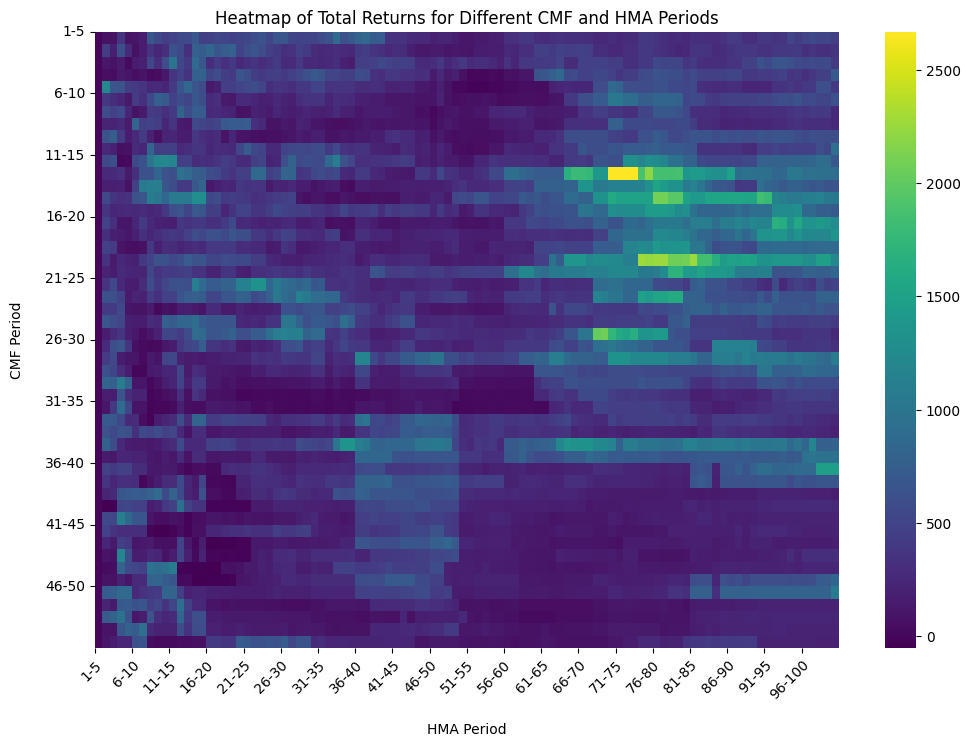


Best CMF Period: 12
Best HMA Period: 70
Best Total Return: 2668.0369780920364


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

# Chaikin Money Flow (CMF)
def calculate_cmf(df, period=20):
    mf_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    mf_volume = mf_multiplier * df['Volume']
    df['CMF'] = mf_volume.rolling(window=period).sum() / df['Volume'].rolling(window=period).sum()
    return df['CMF']

# Hull Moving Average (HMA)
def calculate_hma(df, period=20):
    wma_half = df['Close'].rolling(window=period // 2).mean()
    wma_full = df['Close'].rolling(window=period).mean()
    hma = (2 * wma_half - wma_full).rolling(window=int(np.sqrt(period))).mean()
    df['HMA'] = hma
    return df['HMA']

# Define the stock symbol and time period
symbol = 'NVDA'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Function to backtest strategy with given CMF and HMA periods
def backtest_strategy(cmf_period, hma_period):
    # Calculate CMF and HMA
    df['CMF'] = calculate_cmf(df, period=cmf_period)
    df['HMA'] = calculate_hma(df, period=hma_period)

    # Calculate HMA slope
    df['HMA_Slope'] = df['HMA'] - df['HMA'].shift(1)

    # Define entry and exit signals based on CMF and HMA
    df['Entry'] = (
        (df['CMF'] > 0) &  # Bullish CMF
        (df['HMA_Slope'] > 0) &  # HMA sloping upward
        (df['CMF'].shift(1) <= 0)  # Previous CMF was <= 0
    )

    df['Exit'] = (
        (df['CMF'] < 0) &  # Bearish CMF
        (df['HMA_Slope'] < 0) &  # HMA sloping downward
        (df['CMF'].shift(1) >= 0)  # Previous CMF was >= 0
    )

    # Filter data for test only
    df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Convert signals to boolean arrays
    entries = df_filtered['Entry'].to_numpy()
    exits = df_filtered['Exit'].to_numpy()

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_filtered['Close'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001
    )

    return portfolio.stats().loc['Total Return [%]']  # Return the total return as the metric for optimization

# Define the range of periods to test
cmf_periods = range(1, 51)  # CMF periods from 1 to 50
hma_periods = range(1, 101)  # HMA periods from 1 to 100

# Create all combinations of CMF and HMA periods
parameter_combinations = product(cmf_periods, hma_periods)

# Initialize a matrix to store the results (total return) for each combination of parameters
results = np.zeros((len(cmf_periods), len(hma_periods)))

# Perform the grid search
for i, (cmf_period, hma_period) in enumerate(parameter_combinations):
    print(f"Testing CMF period {cmf_period} and HMA period {hma_period}...")
    total_return = backtest_strategy(cmf_period, hma_period)
    print(f"Total Return: {total_return}")

    # Store the total return in the results matrix
    row = i // len(hma_periods)
    col = i % len(hma_periods)
    results[row, col] = total_return

# Plot the heatmap without numbers
plt.figure(figsize=(12, 8))
sns.heatmap(results, cmap="viridis", annot=False, xticklabels=hma_periods, yticklabels=cmf_periods)

# Adjust x-axis and y-axis ticks to show ranges instead of individual numbers
plt.xticks(ticks=np.arange(0, len(hma_periods), step=5), labels=[f'{x}-{x+4}' for x in range(1, len(hma_periods)+1, 5)], rotation=0)
plt.yticks(ticks=np.arange(0, len(cmf_periods), step=5), labels=[f'{x}-{x+4}' for x in range(1, len(cmf_periods)+1, 5)], rotation=0)

# Rotate x-axis and y-axis labels for better spacing
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-axis labels
plt.yticks(rotation=0, ha="right")  # Keep y-axis labels horizontal

# Add padding to make space between labels and axes
plt.xlabel("HMA Period", labelpad=15)
plt.ylabel("CMF Period", labelpad=15)

plt.title("Heatmap of Total Returns for Different CMF and HMA Periods")
plt.show()

# Output the best parameters and their corresponding performance
best_cmf_period, best_hma_period = divmod(np.argmax(results), len(hma_periods))
best_return = results[best_cmf_period, best_hma_period]

print(f"\nBest CMF Period: {cmf_periods[best_cmf_period]}")
print(f"Best HMA Period: {hma_periods[best_hma_period]}")
print(f"Best Total Return: {best_return}")


In [ ]:
# Download data
symbol = 'NVDA'
start_date = '2020-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)
df_test = df['Close']
pf = vbt.Portfolio.from_holding(df_test, init_cash=100_000)
pf.stats()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,2248392.945661
Total Return [%],2148.392946
Benchmark Return [%],2148.392946
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],66.335088


In [1]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 470.9 kB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


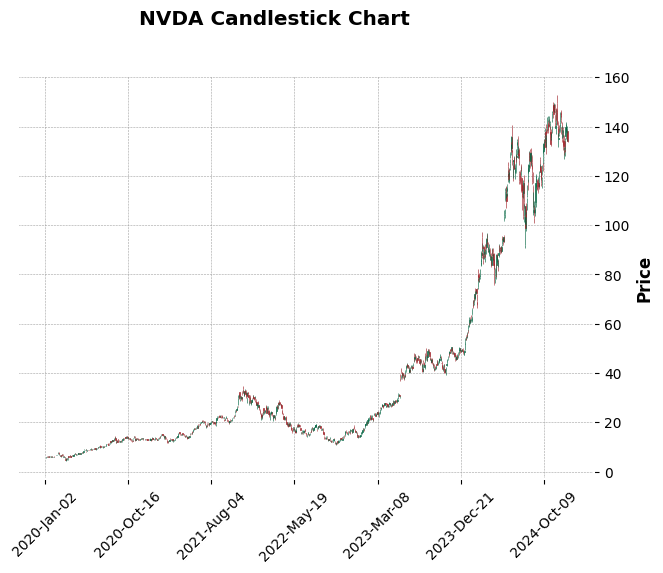

In [5]:
import yfinance as yf
import mplfinance as mpf

# Define the stock symbol and time period
symbol = 'NVDA'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Ensure data is filled forward
df.ffill(inplace=True)

# Plot candlestick chart
mpf.plot(df, type='candle', style='charles', title=f'{symbol} Candlestick Chart')
